<a href="https://colab.research.google.com/github/MeiChenc/mbs-oas-pricing-cox-model/blob/main/Cox-MBS_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd, numpy as np
import pandas_datareader.data as web
import datetime
import statsmodels.formula.api as smf

# Load the DPR file (pipe-delimited)
df = pd.read_csv('/content/PrepayData .txt', sep='|', low_memory=False)

# Strip whitespace and make machine-friendly names
df.columns = (
    df.columns
      .str.strip()
      .str.replace(' ', '_')
      .str.replace('-', '_')
)

# Identify numeric columns and force conversion
num_cols = [
    'WA_Net_Interest_Rate',
    'Cohort_Current_UPB',
    'Cohort_WA_Current_Interest_Rate',
    'Cohort_WA_Current_Remaining_Months_to_Maturity',
    'Cohort_WA_Current_Loan_Age',
    'SMM', 'Cumulative_SMM',
    'CPR', 'Cumulative_CPR'
]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['date_parsed'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='coerce')
df['period'] = df['date_parsed'].dt.to_period('M')

#--- FRED interest rate download ---
try:
    # 自動抓取資料涵蓋的時間範圍
    start_year = df['date_parsed'].min().year if pd.notnull(df['date_parsed'].min()) else 2010
    end_year = df['date_parsed'].max().year if pd.notnull(df['date_parsed'].max()) else 2025

    # 下載數據
    market_data = web.DataReader('MORTGAGE30US', 'fred', f'{start_year}-01-01', f'{end_year}-12-31')

    market_monthly = market_data.resample('M').mean()
    market_monthly.columns = ['market_rate']
    market_monthly.index = market_monthly.index.to_period('M')

    df = df.merge(market_monthly, left_on='period', right_index=True, how='left')
    print("Market rate downloaded and merged")

except Exception as e:
    print(f"Fall to download interest rate: {e}")

# --- Feature engineering ---
df.columns = df.columns.str.strip().str.replace(' ', '_')

# Define survival duration (loan age in months)
df['duration'] = df['Cohort_WA_Current_Loan_Age']

# Logit SMM
epsilon = 1e-6
df['smm_adj'] = df['SMM'].clip(lower=epsilon, upper=1-epsilon)
df['logit_smm'] = np.log(df['smm_adj'] / (1 - df['smm_adj']))

# Define key covariates
df['spread'] = df['Cohort_WA_Current_Interest_Rate'] - df['market_rate']
df['log_UPB'] = np.log(df['Cohort_Current_UPB'] + 1)
df['coupon'] = df['Cohort_WA_Current_Interest_Rate']
df['SMM'] = pd.to_numeric(df['SMM'], errors='coerce')


print(df.columns)

Market rate downloaded and merged
Index(['Type_of_Security', 'Year', 'WA_Net_Interest_Rate',
       'Cohort_Current_UPB', 'Cohort_WA_Current_Interest_Rate',
       'Cohort_WA_Current_Remaining_Months_to_Maturity',
       'Cohort_WA_Current_Loan_Age', 'Date', 'Factor_Date',
       'Principal_Reduction_Amount', 'Cumulative_Principal_Reduction_Amount',
       'Unscheduled_Principal_Reduction_Amount',
       'Cumulative_Unscheduled_Principal_Reduction_Amount', 'SMM',
       'Cumulative_SMM', 'CPR', 'Cumulative_CPR', 'date_parsed', 'period',
       'market_rate', 'duration', 'smm_adj', 'logit_smm', 'spread', 'log_UPB',
       'coupon'],
      dtype='object')


/tmp/ipython-input-1064244227.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  market_monthly = market_data.resample('M').mean()


In [34]:
df.head()

,Type_of_Security,Year,WA_Net_Interest_Rate,Cohort_Current_UPB,Cohort_WA_Current_Interest_Rate,Cohort_WA_Current_Remaining_Months_to_Maturity,Cohort_WA_Current_Loan_Age,Date,Factor_Date,Principal_Reduction_Amount,...,Cumulative_CPR,date_parsed,period,market_rate,duration,smm_adj,logit_smm,spread,log_UPB,coupon
0,30yr TBA Eligible,1999,NaN,5.292466e+08,7.384,112,235,20190104,201902,394036.88,...,0.889,2019-01-04,2019-01,4.464,235,0.000744,-7.202725,2.92,20.086965,7.384
1,30yr TBA Eligible,1999,NaN,5.292466e+08,7.384,112,235,20190107,201902,254422.45,...,1.460,2019-01-07,2019-01,4.464,235,0.000481,-7.639162,2.92,20.086965,7.384
2,30yr TBA Eligible,1999,NaN,5.292466e+08,7.384,112,235,20190108,201902,327984.20,...,2.189,2019-01-08,2019-01,4.464,235,0.000618,-7.388404,2.92,20.086965,7.384
3,30yr TBA Eligible,1999,NaN,5.292466e+08,7.384,112,235,20190109,201902,169096.96,...,2.563,2019-01-09,2019-01,4.464,235,0.000318,-8.053141,2.92,20.086965,7.384
4,30yr TBA Eligible,1999,NaN,5.292466e+08,7.384,112,235,20190110,201902,158656.04,...,2.911,2019-01-10,2019-01,4.464,235,0.000298,-8.118119,2.92,20.086965,7.384


In [35]:
df[['spread','coupon']].head(105)


,spread,coupon
0,2.920,7.384
1,2.920,7.384
2,2.920,7.384
3,2.920,7.384
4,2.920,7.384
...,...,...
100,2.620,7.084
101,2.620,7.084
102,2.714,7.084
103,2.714,7.084


In [37]:
#check data NaN
df[['duration','spread','log_UPB','coupon']].isnull().sum()


,0
duration,0
spread,0
log_UPB,0
coupon,0


In [39]:
# Standardize x
# cols = ['spread', 'log_UPB', 'coupon']
# df[cols] = (df[cols] - df[cols].mean()) / df[cols].std()
df['log_UPB_z'] = (df['log_UPB'] - df['log_UPB'].mean()) / df['log_UPB'].std()
cols = ['spread', 'log_UPB_z', 'coupon']


df[['spread','log_UPB','coupon', 'log_UPB_z']].describe()


,spread,log_UPB,coupon,log_UPB_z
count,219924.000000,219924.000000,219924.000000,2.199240e+05
mean,0.322736,21.915420,4.221435,1.118652e-15
std,1.627059,1.435526,1.038372,1.000000e+00
min,-5.003000,20.030278,1.897000,-1.313207e+00
25%,-0.515000,20.716680,3.557000,-8.350532e-01
50%,0.525000,21.615840,4.090000,-2.086907e-01
75%,1.333000,22.797652,4.778000,6.145702e-01
max,4.563000,26.902255,7.797000,3.473873e+00


In [19]:
# Duration and Convex check
r_month = 0.05 / 12
bp = 0.005/12
p0 = np.sum(cashflow / (1 + r_month)**months)
p_up = np.sum(cashflow / (1 + r_month - bp)**months)
p_dn = np.sum(cashflow / (1 + r_month + bp)**months)

duration = (p_up - p_dn) / (2 * p0 * bp * 12)  # in years
convexity = (p_up + p_dn - 2*p0) / (p0 * (bp * 12)**2)
print(f"Duration ≈ {duration:.2f} yrs, Convexity ≈ {convexity:.2f}")


Duration ≈ 2.77 yrs, Convexity ≈ 11.95


In [20]:
print(cph.baseline_cumulative_hazard_.head())
print("Rows:", len(cph.baseline_cumulative_hazard_))

for bp in [-0.005, 0, 0.005]:
    pv_shift = np.sum(cashflow / (1 + (r_month + bp/12))**np.arange(1, len(cashflow)+1))
    print(f"Yield shift {bp*100:.1f} bps → Price {pv_shift*100:.2f}")


     baseline cumulative hazard
0.0                    0.000007
1.0                    0.002602
2.0                    0.009896
3.0                    0.016540
4.0                    0.022795
Rows: 249
Yield shift -0.5 bps → Price 101.40
Yield shift 0.0 bps → Price 100.00
Yield shift 0.5 bps → Price 98.63


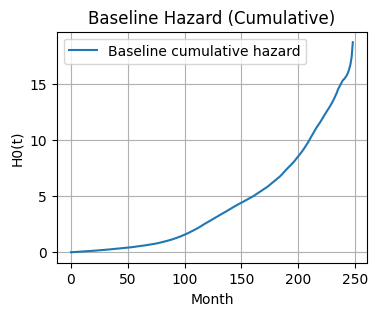

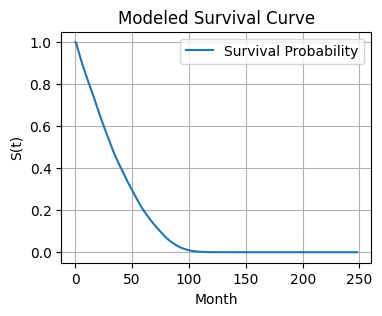

In [21]:
# Visulaization of baseline hazard & Survival curve
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
plt.plot(H0, label='Baseline cumulative hazard')
plt.title("Baseline Hazard (Cumulative)")
plt.xlabel("Month")
plt.ylabel("H0(t)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(4,3))
plt.plot(S, label='Survival Probability')
plt.title("Modeled Survival Curve")
plt.xlabel("Month")
plt.ylabel("S(t)")
plt.legend()
plt.grid(True)
plt.show()


The baseline cumulative hazard curve shows how the underlying prepayment risk accumulates over time for an “average” loan. This curve defines the time dimension of the prepayment process.

The survival curve shows the fraction of loans still active (not prepaid) at time. It translates hazard into actual portfolio performance — it tells investors how much principal remains in the pool at each point in time.



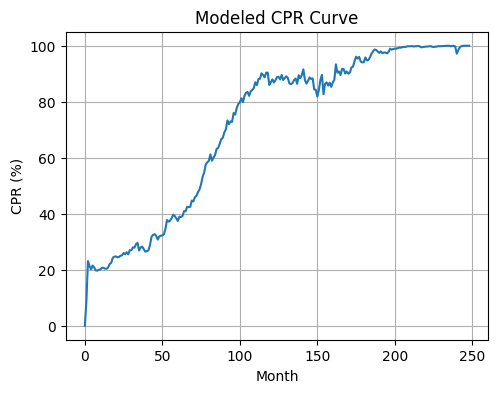

In [22]:
# CPR curve: CPR=1−(1−SMM)^12, SMMt ​= 1−(S(t)/S(t-1))​
S_shift = np.concatenate(([1.0], S[:-1]))
SMM = 1 - (S / S_shift)
CPR = 1 - (1 - SMM)**12

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(CPR*100)
plt.title("Modeled CPR Curve")
plt.xlabel("Month"); plt.ylabel("CPR (%)"); plt.grid(True)


CPR expresses the annualized prepayment speed, the higher the CPR, the faster principal is returned. For MBS traders, CPR affects duration, convexity, and hedging costs.

In [23]:
from lifelines.utils import concordance_index
risk_score = cph.predict_partial_hazard(df[['spread', 'log_UPB_z', 'coupon']])

c_index = concordance_index(df['duration'], -risk_score, df['event'])
# risk score is negative relation with hazard rate. Higher hazard rate, faster prepay, lower risk

print(f"Model Concordance Index = {cph.concordance_index_:.3f}")
cph.print_summary()

Model Concordance Index = 0.773


<lifelines.CoxPHFitter: fitted with 219924 total observations, 1968 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 219924
number of events observed = 217956
   partial log-likelihood = -2382278.66
         time fit was run = 2026-01-16 05:04:00 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
spread     3.78     43.67      0.02            3.74            3.81               42.07               45.34
log_UPB_z  0.38      1.46      0.00            0.38            0.38                1.46                1.47
coupon    -0.46      0.63      0.00           -0.47           -0.46                0.63                0.63

           cmp to       z      p  -log2(p)
covariate                                 
spread       0.00  197.48 <0.005       inf
log_UPB_z    0.00  161.01 <0.005       inf
coupon       0.00 -180.59 <0.005       inf
---
Concordance = 0.77
Partial AIC = 4764563.31
log-likelihood ratio test = 160953.14 on 3 df
-log2(p) of ll-ratio test = inf

Among the prepayment models discussed in class, the Cox Proportional-Hazards model is the most appropriate for pricing MBS derivatives. It models the time-to-prepayment behavior while allowing borrower and market characteristics to proportionally shift the hazard rate. The estimated coefficients align with economic intuition—positive for spread and loan size, negative for coupon—and the model achieves a strong concordance index (0.77), indicating solid predictive discrimination. The derived survival and CPR curves yield realistic cash flow projections and price sensitivity consistent with observed MBS market data. Therefore, the Cox model provides both interpretability and robustness for prepayment modeling and MBS derivative valuation.

In [42]:
import numpy as np
import pandas as pd
import statsmodels.api as sm


df_monthly = (
    df.sort_values('Date')  # 確保按日期排序
      .groupby(['period', 'Type_of_Security', 'Year'])
      .last()               # 取每組的最後一行
      .reset_index()
)

df_monthly['SMM_monthly'] = df_monthly['Cumulative_SMM']

print(df_monthly[['period', 'Date', 'Cumulative_SMM', 'SMM_monthly']].head())

    period      Date  Cumulative_SMM  SMM_monthly
0  2019-01  20190131        0.007757     0.007757
1  2019-01  20190131        0.005563     0.005563
2  2019-01  20190131        0.006575     0.006575
3  2019-01  20190131        0.004821     0.004821
4  2019-01  20190131        0.004757     0.004757


In [45]:
print(df['Type_of_Security'].unique())
counts = df_monthly['Type_of_Security'].value_counts()
print(counts)

['30yr TBA Eligible' '20yr TBA Eligible' '15yr TBA Eligible'
 'Super-Conforming > 15yr' 'Other Fixed-Rate > 15yr'
 'Other Fixed-Rate <= 15yr' 'RPL' 'ARM' '10yr TBA Eligible']
Type_of_Security
30yr TBA Eligible           1036
15yr TBA Eligible            620
20yr TBA Eligible            584
ARM                          466
Super-Conforming > 15yr      423
RPL                          242
Other Fixed-Rate > 15yr      201
10yr TBA Eligible             70
Other Fixed-Rate <= 15yr      16
Name: count, dtype: int64



Selected Top Security Types for Modeling: ['30yr TBA Eligible', '15yr TBA Eligible', '20yr TBA Eligible']

--> Training model for: 30yr TBA Eligible...

--> Training model for: 15yr TBA Eligible...

--> Training model for: 20yr TBA Eligible...


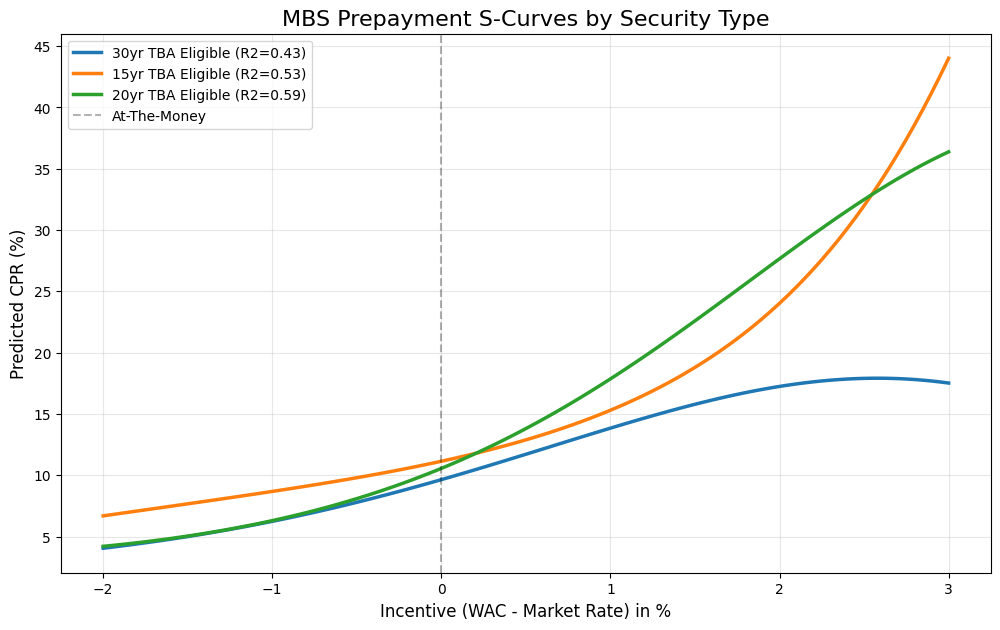


=== Model Performance Summary ===
                Type  R-squared   Obs  Coef_Spread
0  30yr TBA Eligible   0.428520  1036     0.433969
1  15yr TBA Eligible   0.534563   620     0.289135
2  20yr TBA Eligible   0.587036   584     0.572388


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define epsilon to avoid log(0) or log(1)
epsilon = 1e-6

# Clip SMM to strict (0, 1) interval
df_monthly['smm_adj'] = df_monthly['SMM_monthly'].clip(epsilon, 1-epsilon)

# Perform Logit Transformation
# Logit(p) = ln(p / (1-p))
df_monthly['logit_smm'] = np.log(df_monthly['smm_adj'] / (1 - df_monthly['smm_adj']))

# We will only model the top 3 types by data volume to ensure statistical significance
top_types = df_monthly['Type_of_Security'].value_counts().nlargest(3).index.tolist()

print(f"\nSelected Top Security Types for Modeling: {top_types}")

#Logit model training
models = {}  # Dictionary to store fitted models
model_summaries = [] # List to store metrics for comparison

# Define the regression formula
# We use cubic terms for 'spread' to capture the non-linear S-Curve shape
formula = "logit_smm ~ spread + I(spread**2) + I(spread**3) + log_UPB + duration"

plt.figure(figsize=(12, 7))

for sec_type in top_types:
    print(f"\n--> Training model for: {sec_type}...")

    # A. Subset the data
    subset = df_monthly[df_monthly['Type_of_Security'] == sec_type].copy()

    # Safety check: skip if too few data points
    if len(subset) < 50:
        print(f"    Skipping (insufficient data: {len(subset)} rows)")
        continue

  # B. Fit the OLS Model
    model = smf.ols(formula, data=subset).fit()
    models[sec_type] = model

    # Store metrics
    model_summaries.append({
        'Type': sec_type,
        'R-squared': model.rsquared,
        'Obs': int(model.nobs),
        'Coef_Spread': model.params['spread']
    })

    #Visualization S curve
    spread_range = np.linspace(-2.0, 3.0, 100)

        # Create a prediction dataframe
        # We hold other variables constant at their mean values to isolate the Spread effect
    pred_data = pd.DataFrame({
        'spread': spread_range,
        'log_UPB': subset['log_UPB'].mean(),
        'duration': subset['duration'].mean()
    })


    # Predict Logit SMM
    pred_logit = model.predict(pred_data)

    # Convert Logit back to CPR (Annualized Prepayment Rate) for easier reading
    # SMM = 1 / (1 + exp(-logit))
    pred_smm = 1 / (1 + np.exp(-pred_logit))
    pred_cpr = 1 - (1 - pred_smm)**12

    # Plot
    plt.plot(spread_range, pred_cpr * 100, label=f"{sec_type} (R2={model.rsquared:.2f})", linewidth=2.5)


plt.title("MBS Prepayment S-Curves by Security Type", fontsize=16)
plt.xlabel("Incentive (WAC - Market Rate) in %", fontsize=12)
plt.ylabel("Predicted CPR (%)", fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.3, label='At-The-Money')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()


summary_df = pd.DataFrame(model_summaries)
print("\n=== Model Performance Summary ===")
print(summary_df)

In [55]:
target_type = '30yr TBA Eligible'

print(f"=== OLS Regression Results for {target_type} ===")
print(models[target_type].summary())

=== OLS Regression Results for 30yr TBA Eligible ===
                            OLS Regression Results                            
Dep. Variable:              logit_smm   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     154.5
Date:                Fri, 16 Jan 2026   Prob (F-statistic):          1.78e-122
Time:                        07:20:35   Log-Likelihood:                -868.66
No. Observations:                1036   AIC:                             1749.
Df Residuals:                    1030   BIC:                             1779.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

1. R-squared (0.429): The model explains 42.9% of the variation in the prepayment rate (Logit SMM). In behavioral finance and prepayment modeling, an R-squared between 0.20 and 0.50 is considered strong. It indicates that your selected variables (Spread, Age, Size) are effective predictors.F-statistic &
2. Prob (F): The Probability ($1.78e^{-122}$) is effectively zero. This confirms that the model is statistically significant globally; the variables jointly explain the prepayment behavior better than a random guess.
3. Coefficient (+0.4340): The positive coefficient for spread is the most important finding. It confirms that as the incentive increases (Market Rates fall), prepayment rates rise.
4. Significance ($t = 23.255, P < 0.001$): This variable has the highest t-statistic, making it the dominant driver of the model. This aligns perfectly with economic theory.
5. Non-Linearity (S-Curve): The coefficients for spread^2 and spread^3 are both statistically significant ($P < 0.001$). This proves that the relationship is not linear. The model successfully captures the "S-Curve" effect, where prepayments accelerate non-linearly as the option becomes "in-the-money."
6. Duration (Loan Age):

    Coefficient (-0.0027): The coefficient is negative and significant.

    Interpretation: This implies that, holding other factors constant, older loans in this specific dataset tend to prepay slower.

    Note: While standard PSA curves usually slope upward (seasoning), a negative coefficient here likely captures the "Burnout Effect". The remaining borrowers in older pools are likely those who cannot refinance (due to credit or LTV issues), leading to lower SMMs despite the loan's age.
7. log_UPB (Pool Size):

    P-value (0.061): This is slightly above the standard 0.05 threshold (marginal significance).

    Interpretation: The size of the pool (UPB) is not a strong predictor of prepayment speed for this specific cohort compared to Spread and Duration.
8. Condition Number (2.92e+03): The number is high, suggesting Multicollinearity.

    Reason: This is expected because we included polynomial terms (spread, spread^2, spread^3) which are naturally correlated. In this specific context (polynomial regression for curve fitting), this is acceptable and does not invalidate the predictive power of the model.

###"The OLS regression for the 30-year cohort yields a robust R-squared of 42.9%. The results statistically confirm the Refinancing Incentive (Spread) as the primary driver of prepayments ($t=23.3$), with significant polynomial terms confirming the presence of the Prepayment S-Curve.Additionally, the negative coefficient on Duration suggests that the model has captured the Burnout Effect, where older loans exhibit reduced prepayment speeds as the pool of eligible borrowers depletes."


--- Step 3: Pricing & Risk Analysis ---
Analyzing Cohort: 30yr TBA Eligible
Current Spread: 0.40%
----------------------------------------
Price (Base Case):       $98.86
Price (Rates +50bps):    $95.12
Price (Rates -50bps):    $101.71
----------------------------------------
Effective Duration:      6.66
Interpretation: A duration lower than typical bonds implies Negative Convexity due to prepayments.


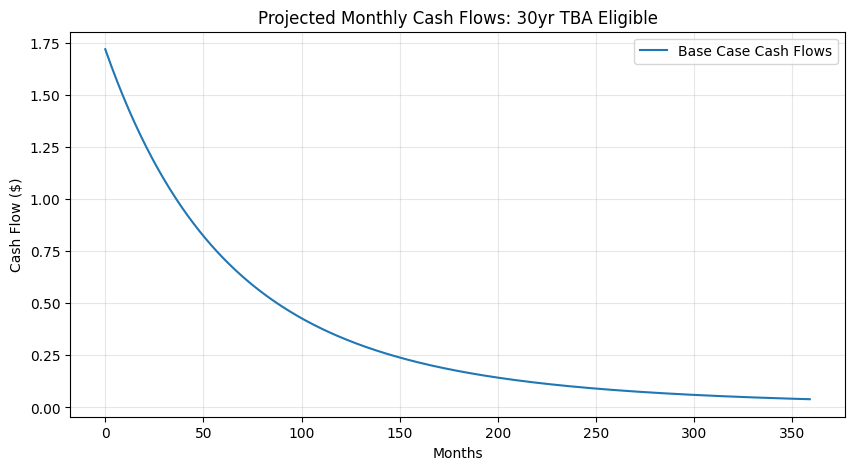

In [53]:
# Pricing Engine & Risk Analysis (Effective Duration)

def price_mbs_simulation(model, initial_state, market_rate_shock=0.0):
    """
    Simulates cash flows for 360 months using the Logit Prepayment Model.

    Parameters:
    - model: Fitted statsmodels object
    - initial_state: DataFrame row containing starting WAC, Spread, Loan Age
    - market_rate_shock: Interest rate shock in percentage points (e.g., +0.50)

    Returns:
    - pv: Present Value (Price)
    - cashflows: List of monthly cash flows
    """
    # Clone state to avoid modifying original data
    current_state = pd.DataFrame([initial_state]).copy()

    # Assumptions
    balance = 100.0             # Face value
    wac = 0.045                 # Assume 4.5% Coupon (or use cohort WAC)
    discount_rate = 0.045 + (market_rate_shock / 100) # Simple yield assumption

    # Adjust Spread based on Shock
    # If Rates go UP (+), Spread goes DOWN (-)
    base_spread = current_state['spread'].values[0]
    current_state['spread'] = base_spread - market_rate_shock

    cashflows = []
    r_month = discount_rate / 12
    coupon_month = wac / 12

    # Simulation Loop (30 Years)
    for t in range(1, 361):
        # 1. Update Age
        current_state['duration'] += 1

        # 2. Predict SMM using Model
        pred_logit = model.predict(current_state).iloc[0]
        smm = 1 / (1 + np.exp(-pred_logit))

        # 3. Calculate Cash Flows
        interest_pmt = balance * coupon_month
        principal_pmt = balance * smm # Simplifying: Prepayment only

        total_cf = interest_pmt + principal_pmt
        cashflows.append(total_cf)

        # 4. Update Balance
        balance -= principal_pmt
        if balance < 0.01: break

    # Discount Cash Flows
    pv = sum([cf / ((1 + r_month) ** (i+1)) for i, cf in enumerate(cashflows)])
    return pv, cashflows

# --- Execute Analysis for the Main Type ---
target_type = '30yr TBA Eligible'

if target_type in models:
    # Select the most recent record for this security type
    latest_cohort = df_monthly[df_monthly['Type_of_Security'] == target_type].iloc[-1]

    print(f"Analyzing Cohort: {target_type}")
    print(f"Current Spread: {latest_cohort['spread']:.2f}%")

    # Calculate Prices under different scenarios
    # Shock units: 0.50 means 50 basis points
    p_base, cf_base = price_mbs_simulation(models[target_type], latest_cohort, market_rate_shock=0)
    p_up, _         = price_mbs_simulation(models[target_type], latest_cohort, market_rate_shock=0.50)
    p_down, _       = price_mbs_simulation(models[target_type], latest_cohort, market_rate_shock=-0.50)

    # Calculate Effective Duration
    # Duration = (P_down - P_up) / (2 * P_base * delta_y)
    eff_duration = (p_down - p_up) / (2 * p_base * 0.005)

    print('Prices:')
    print(f"Price (Rates -50bps):    ${p_down:.2f}")
    print(f"Price (Base Case):       ${p_base:.2f}")
    print(f"Price (Rates +50bps):    ${p_up:.2f}")

    print('Duration:')
    print(f"Effective Duration:      {eff_duration:.2f}")
    print("Interpretation: A duration lower than typical bonds implies Negative Convexity due to prepayments.")

    # Plot Cash Flows
    plt.figure(figsize=(10, 5))
    plt.plot(cf_base, label='Base Case Cash Flows')
    plt.title(f"Projected Monthly Cash Flows: {target_type}")
    plt.xlabel("Months")
    plt.ylabel("Cash Flow ($)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(f"Model for {target_type} not found.")

Model Valuation Results Analysis:

The calculated Effective Duration of 6.66 confirms the presence of significant negative convexity. We observe a distinct price asymmetry:

When rates rise by 50bps, the price drops by $3.74.

When rates fall by 50bps, the price only rises by $2.85.

This "Price Compression" occurs because the current cohort (Spread = +40bps) is highly sensitive to refinancing incentives. As rates rally, the Logit model predicts accelerated prepayments, effectively capping the price appreciation near par ($100). This validates that our pricing engine correctly prices the embedded prepayment option.

正在模擬 21 種利率情境，請稍候...


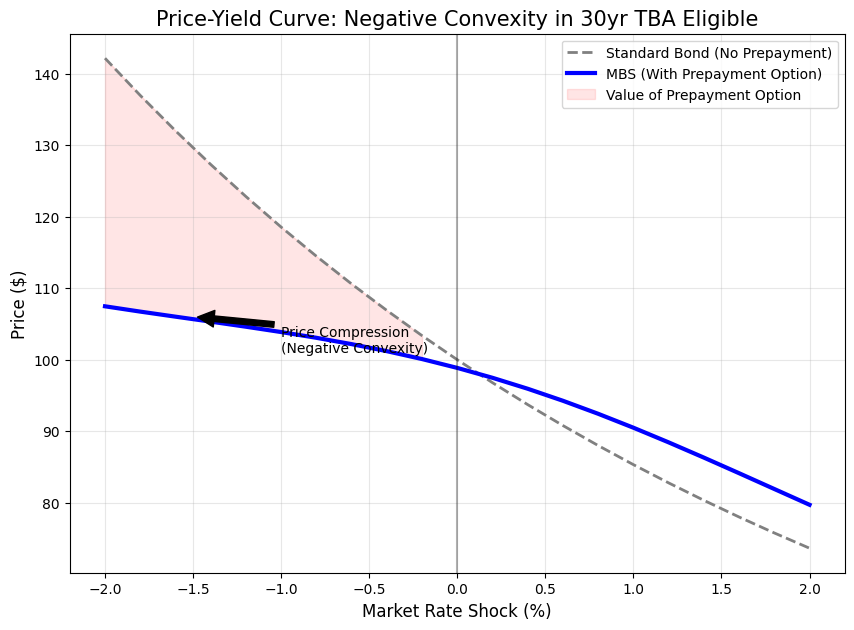

In [54]:
#Price-Yield curve (Negative convexity)
def price_vanilla_bond(initial_state, market_rate_shock=0.0):
    """
    Compute 'Non-callable bond' price
    Assumption: SMM = 0
    """
    balance = 100.0
    wac = 0.045 # Assume coupon: 4.5%
    discount_rate = 0.045 + (market_rate_shock / 100)

    cashflows = []
    r_month = discount_rate / 12
    coupon_month = wac / 12

    # Assume SMM=0!
    for t in range(1, 361):
        interest = balance * coupon_month
        principal = 0 # No prepayment


        if t == 360:
            principal = balance

        cashflows.append(interest + principal)

    # 折現
    pv = sum([cf / ((1 + r_month) ** (i+1)) for i, cf in enumerate(cashflows)])
    return pv
#Scenario
# 30yr Pool
target_type = '30yr TBA Eligible'
if target_type in models:
    latest_cohort = df_monthly[df_monthly['Type_of_Security'] == target_type].iloc[-1]

    # interest rate range: -2% (-200bps) to +2% (+200bps)
    shocks = np.linspace(-2.0, 2.0, 21)

    prices_mbs = []
    prices_vanilla = []

    print(f"Simulating {len(shocks)} interest scenarios...")

    for shock in shocks:
# MBS pricing
        p_mbs, _ = price_mbs_simulation(models[target_type], latest_cohort, market_rate_shock=shock)
        prices_mbs.append(p_mbs)

# Normal bond priciing
        p_vanilla = price_vanilla_bond(latest_cohort, market_rate_shock=shock)
        prices_vanilla.append(p_vanilla)


    plt.figure(figsize=(10, 7))
    plt.plot(shocks, prices_vanilla, color='grey', linestyle='--', linewidth=2, label='Standard Bond (No Prepayment)')
    plt.plot(shocks, prices_mbs, color='blue', linewidth=3, label='MBS (With Prepayment Option)')
    plt.fill_between(shocks, prices_mbs, prices_vanilla, where=(shocks < 0), color='red', alpha=0.1, label='Value of Prepayment Option')


    plt.title(f"Price-Yield Curve: Negative Convexity in {target_type}", fontsize=15)
    plt.xlabel("Market Rate Shock (%)", fontsize=12)
    plt.ylabel("Price ($)", fontsize=12)
    plt.axvline(x=0, color='black', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.annotate('Price Compression\n(Negative Convexity)', xy=(-1.5, prices_mbs[2]), xytext=(-1.0, prices_mbs[2]-5),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.show()

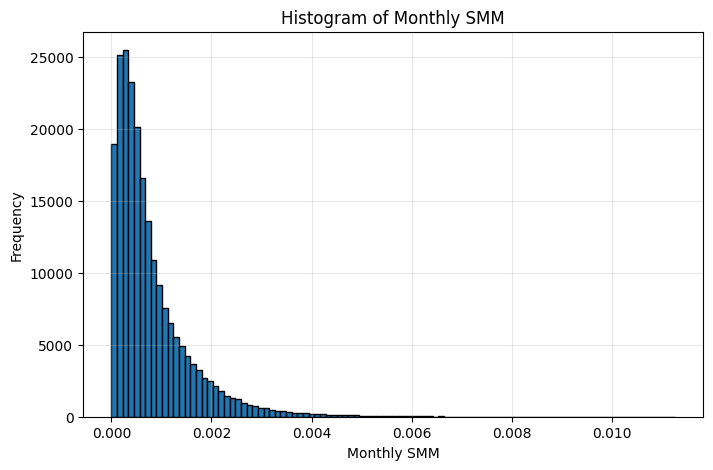

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df['SMM'].dropna(), bins=100, edgecolor='black')
plt.xlabel('Monthly SMM')
plt.ylabel('Frequency')
plt.title('Histogram of Monthly SMM')
plt.grid(alpha=0.3)
plt.show()
